# SETUP

In [1]:
from google.colab import files
uploaded = files.upload()

Saving causality_mirrored_mcq.csv to causality_mirrored_mcq.csv


In [2]:
!pip install datasets

!pip install transformers==4.42.4

!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 80.3 MB/s eta 0:00:00
   ━

In [3]:
import os
import random

import torch
import openai
import chardet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import accuracy_score

# DATA PROCESSING

## Load the original dataset

In [9]:
dataset_name = "causality_mirrored_mcq"

# Detect file encoding
with open(f"{dataset_name}.csv", 'rb') as f:
    result = chardet.detect(f.read())
    print(result['encoding'])

# Use detected encoding
causality_dataset = pd.read_csv(f"{dataset_name}.csv", encoding=result['encoding'])

Windows-1252


In [10]:
causality_dataset.sample(n=5, random_state=42)

,Premise,Question,Option A,Option B,Answer,Category
110,The school's scheduling was impacted by extern...,What's the more plausible CAUSE?,There was a power outage scheduled for the ori...,A new course was introduced in the curriculum.,B,Cause
419,"Overwhelmed with responsibilities, a man strug...",What's the more plausible RESULT?,He maintained a regular and consistent communi...,He forgot to call his parents altogether.,B,Effect
565,"A fitness enthusiast, armed with knowledge and...",What's the more plausible RESULT?,He wrote a book on fitness.,He improved his physical health and built a ha...,A,Effect
77,The family's celebration was not just about a ...,What's the more plausible CAUSE?,They were marking the end of years of financia...,They were celebrating a festival.,B,Cause
181,His spent the night exploring a new technical ...,What's the more plausible CAUSE?,There was a critical bug that needed fixing be...,He wanted to learn a new programming language.,B,Cause


## Add labels of Options' Relationship

In [17]:
causality_dataset["Expected Relationship"] = "High"

In [18]:
causality_dataset.sample(n=5, random_state=42)

,Premise,Question,Option A,Option B,Answer,Category,Expected Relationship
110,The school's scheduling was impacted by extern...,What's the more plausible CAUSE?,There was a power outage scheduled for the ori...,A new course was introduced in the curriculum.,B,Cause,High
419,"Overwhelmed with responsibilities, a man strug...",What's the more plausible RESULT?,He maintained a regular and consistent communi...,He forgot to call his parents altogether.,B,Effect,High
565,"A fitness enthusiast, armed with knowledge and...",What's the more plausible RESULT?,He wrote a book on fitness.,He improved his physical health and built a ha...,A,Effect,High
77,The family's celebration was not just about a ...,What's the more plausible CAUSE?,They were marking the end of years of financia...,They were celebrating a festival.,B,Cause,High
181,His spent the night exploring a new technical ...,What's the more plausible CAUSE?,There was a critical bug that needed fixing be...,He wanted to learn a new programming language.,B,Cause,High


## Split based on causes/effects

In [19]:
# Split Cause and Effect based on the Category feature
cause_rows = causality_dataset[causality_dataset['Category'] == "Cause"]
effect_rows = causality_dataset[causality_dataset['Category'] == "Effect"]

In [20]:
cause_rows_name = f"cause_rows_in_dataset_{dataset_name}.csv"
effect_rows_name = f"effect_rows_in_dataset_{dataset_name}.csv"

In [21]:
cause_rows.to_csv(cause_rows_name, index=False)
effect_rows.to_csv(effect_rows_name, index=False)

In [22]:
cause_rows.head()

,Premise,Question,Option A,Option B,Answer,Category,Expected Relationship
0,The government recently passed a nationwide ma...,What's the more plausible CAUSE?,They were following a nationwide mandate to cu...,They were attempting to foster deeper connecti...,A,Cause,High
1,A delivery van was spotted stopping at several...,What's the more plausible CAUSE?,A package was delivered to the house.,A stranger was loitering near the house.,A,Cause,High
2,The office was bustling with activity due to a...,What's the more plausible CAUSE?,The company was hosting a corporate event.,There was a break-in attempt.,A,Cause,High
3,Marine biologists announced a significant disc...,What's the more plausible CAUSE?,Such frequency was to accommodate the higher n...,A new species of fish was found in the ocean.,B,Cause,High
4,Weather reports predicted unusually high tempe...,What's the more plausible CAUSE?,There was a heatwave.,It had snowed overnight.,A,Cause,High


In [23]:
effect_rows.head()

,Premise,Question,Option A,Option B,Answer,Category,Expected Relationship
300,A scientist embarks on a groundbreaking projec...,What's the more plausible RESULT?,"After several months, a promising candidate wa...","After a day, the scientist had built a time ma...",B,Effect,High
301,Despite being meticulous about dental hygiene ...,What's the more plausible RESULT?,He maintained a perfect smile.,He developed cavities over time.,A,Effect,High
302,"A highly efficient team, recognized for their ...",What's the more plausible RESULT?,They decided to start a new project immediately.,They successfully met the deadline the next mo...,A,Effect,High
303,An artist spends a whole day in a flurry of cr...,What's the more plausible RESULT?,He managed to capture the perfect hue and shad...,He went out for dinner in the evening.,B,Effect,High
304,A farmer contemplates diversifying his farming...,What's the more plausible RESULT?,"Over a couple of seasons, the yield from his f...",He decided to start a poultry farm on his prop...,B,Effect,High


In [34]:
files.download(cause_rows_name)
files.download(effect_rows_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Split based on Option A/B

In [24]:
# Prepare text data for embedding
cause_option_a = cause_rows['Option A'].tolist()
cause_option_b = cause_rows['Option B'].tolist()
effect_option_a = effect_rows['Option A'].tolist()
effect_option_b = effect_rows['Option B'].tolist()

In [30]:
# Create a pandas DataFrame
data = {
    "Cause A": cause_option_a,
    "Cause B": cause_option_b,
    "Cause Expected Relationship": cause_rows["Expected Relationship"].tolist(),
    "Effect A": effect_option_a,
    "Effect B": effect_option_b,
    "Effect Expected Relationship": effect_rows["Expected Relationship"].tolist(),
}
causes_effects_df = pd.DataFrame(data)

In [31]:
causes_effects_df.head()

,Cause A,Cause B,Cause Expected Relationship,Effect A,Effect B,Effect Expected Relationship
0,They were following a nationwide mandate to cu...,They were attempting to foster deeper connecti...,High,"After several months, a promising candidate wa...","After a day, the scientist had built a time ma...",High
1,A package was delivered to the house.,A stranger was loitering near the house.,High,He maintained a perfect smile.,He developed cavities over time.,High
2,The company was hosting a corporate event.,There was a break-in attempt.,High,They decided to start a new project immediately.,They successfully met the deadline the next mo...,High
3,Such frequency was to accommodate the higher n...,A new species of fish was found in the ocean.,High,He managed to capture the perfect hue and shad...,He went out for dinner in the evening.,High
4,There was a heatwave.,It had snowed overnight.,High,"Over a couple of seasons, the yield from his f...",He decided to start a poultry farm on his prop...,High


In [32]:
causes_effects_df_name = f"causes_effects_from_dataset_{dataset_name}.csv"
causes_effects_df.to_csv(causes_effects_df_name, index=False)

In [33]:
files.download(causes_effects_df_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# EMBEDDING

In [ ]:
# Load the NV-Embed-v2 model and tokenizer
model = AutoModel.from_pretrained("nvidia/NV-Embed-v2", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("nvidia/NV-Embed-v2", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.66k [00:00<?, ?B/s]

configuration_nvembed.py:   0%|          | 0.00/3.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/NV-Embed-v2:
- configuration_nvembed.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_nvembed.py:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/NV-Embed-v2:
- modeling_nvembed.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/789M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
# Method to generate embeddings
def get_embeddings(texts, batch_size=8, max_length=512):
    return model._do_encode(texts, batch_size=batch_size, max_length=max_length, num_workers=0, return_numpy=True)

In [ ]:
# Generate embeddings and save as CSV
if cause_option_a:
    cause_a_embeddings = get_embeddings(cause_option_a)
    pd.DataFrame(cause_a_embeddings).to_csv("cause_a_embeddings.csv", index=False)
    print("Cause A Embeddings saved as 'cause_a_embeddings.csv'")

if cause_option_b:
    cause_b_embeddings = get_embeddings(cause_option_b)
    pd.DataFrame(cause_b_embeddings).to_csv("cause_b_embeddings.csv", index=False)
    print("Cause B Embeddings saved as 'cause_b_embeddings.csv'")

if effect_option_a:
    effect_a_embeddings = get_embeddings(effect_option_a)
    pd.DataFrame(effect_a_embeddings).to_csv("effect_a_embeddings.csv", index=False)
    print("Effect A Embeddings saved as 'effect_a_embeddings.csv'")

if effect_option_b:
    effect_b_embeddings = get_embeddings(effect_option_b)
    pd.DataFrame(effect_b_embeddings).to_csv("effect_b_embeddings.csv", index=False)
    print("Effect B Embeddings saved as 'effect_b_embeddings.csv'")

encoding:   0%|          | 0/38 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/transformers_modules/nvidia/NV-Embed-v2/7604d305b621f14095a1aa23d351674c2859553a/modeling_nvembed.py:349: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Cause A Embeddings saved as 'cause_a_embeddings.csv'


encoding:   0%|          | 0/38 [00:00<?, ?it/s]

Cause B Embeddings saved as 'cause_b_embeddings.csv'


encoding:   0%|          | 0/38 [00:00<?, ?it/s]

Effect A Embeddings saved as 'effect_a_embeddings.csv'


encoding:   0%|          | 0/38 [00:00<?, ?it/s]

Effect B Embeddings saved as 'effect_b_embeddings.csv'


In [ ]:
files.download("cause_a_embeddings.csv")
files.download("cause_b_embeddings.csv")
files.download("effect_a_embeddings.csv")
files.download("effect_b_embeddings.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded_embeddings = files.upload()

Saving cause_a_embeddings.csv to cause_a_embeddings.csv
Saving cause_b_embeddings.csv to cause_b_embeddings.csv
Saving effect_a_embeddings.csv to effect_a_embeddings.csv
Saving effect_b_embeddings.csv to effect_b_embeddings.csv


# COSINE SIMILARITY VERYFYING

## Option A vs Option B

In [37]:
# Load embeddings from saved CSV files
cause_a_embeddings = pd.read_csv("cause_a_embeddings.csv").values
cause_b_embeddings = pd.read_csv("cause_b_embeddings.csv").values
effect_a_embeddings = pd.read_csv("effect_a_embeddings.csv").values
effect_b_embeddings = pd.read_csv("effect_b_embeddings.csv").values

# Calculate cosine similarities for Cause
cause_cosine_similarities = cosine_similarity(cause_a_embeddings, cause_b_embeddings).diagonal()
cause_rows['Cosine Similarity'] = cause_cosine_similarities

# Calculate cosine similarities for Effect
effect_cosine_similarities = cosine_similarity(effect_a_embeddings, effect_b_embeddings).diagonal()
effect_rows['Cosine Similarity'] = effect_cosine_similarities

# Combine Cause and Effect rows back into a single DataFrame
updated_dataset = pd.concat([cause_rows, effect_rows], ignore_index=True)

<ipython-input-37-8a4ded0b3d3f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cause_rows['Cosine Similarity'] = cause_cosine_similarities
<ipython-input-37-8a4ded0b3d3f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_rows['Cosine Similarity'] = effect_cosine_similarities


In [38]:
# Save the updated dataset to a new CSV
output_path = "updated_dataset_with_options_cosine_similarity.csv"

In [39]:
updated_dataset.to_csv(output_path, index=False)

In [40]:
updated_dataset.sample(n=5, random_state=42)

,Premise,Question,Option A,Option B,Answer,Category,Expected Relationship,Cosine Similarity
110,The school's scheduling was impacted by extern...,What's the more plausible CAUSE?,There was a power outage scheduled for the ori...,A new course was introduced in the curriculum.,B,Cause,High,0.170305
419,"Overwhelmed with responsibilities, a man strug...",What's the more plausible RESULT?,He maintained a regular and consistent communi...,He forgot to call his parents altogether.,B,Effect,High,0.479486
565,"A fitness enthusiast, armed with knowledge and...",What's the more plausible RESULT?,He wrote a book on fitness.,He improved his physical health and built a ha...,A,Effect,High,0.515482
77,The family's celebration was not just about a ...,What's the more plausible CAUSE?,They were marking the end of years of financia...,They were celebrating a festival.,B,Cause,High,0.337150
181,His spent the night exploring a new technical ...,What's the more plausible CAUSE?,There was a critical bug that needed fixing be...,He wanted to learn a new programming language.,B,Cause,High,0.205890


In [41]:
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded_updated_dataset = files.upload()

Saving updated_dataset_with_options_cosine_similarity.csv to updated_dataset_with_options_cosine_similarity.csv


In [ ]:
# Save the updated dataset to a new CSV
output_path = "updated_dataset_with_options_cosine_similarity.csv"
updated_dataset = pd.read_csv(output_path)

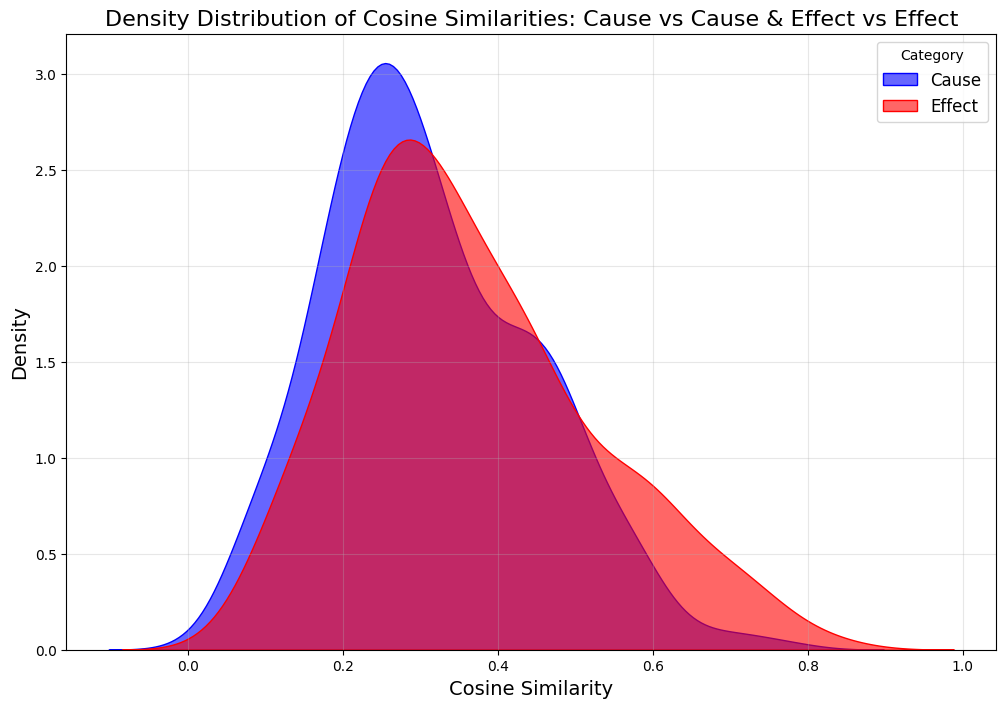

In [ ]:
# Extract cosine similarities for Cause and Effect
cause_cosine_similarities = updated_dataset[updated_dataset["Category"] == "Cause"]["Cosine Similarity"]
effect_cosine_similarities = updated_dataset[updated_dataset["Category"] == "Effect"]["Cosine Similarity"]

# Plot density distributions
plt.figure(figsize=(12, 8))
sns.kdeplot(cause_cosine_similarities, fill=True, color="blue", alpha=0.6, label="Cause")
sns.kdeplot(effect_cosine_similarities, fill=True, color="red", alpha=0.6, label="Effect")

# Add titles and labels
plt.title("Density Distribution of Cosine Similarities: Cause vs Cause & Effect vs Effect", fontsize=16)
plt.xlabel("Cosine Similarity", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12, title="Category")
plt.grid(alpha=0.3)

# Show plot
plt.show()